In [1]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 14px;
</style>
CUDA_LAUNCH_BLOCKING=1

In [2]:
!pip3 install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html


In [3]:
!pip install timm ipywidgets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [4]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [5]:
!pip install git+https://github.com/KinWaiCheuk/nnAudio.git#subdirectory=Installation

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/KinWaiCheuk/nnAudio.git to /tmp/pip-req-build-v2rp0twv
  Running command git clone -q https://github.com/KinWaiCheuk/nnAudio.git /tmp/pip-req-build-v2rp0twv
  Resolved https://github.com/KinWaiCheuk/nnAudio.git to commit 744fab12497a5316153978de2e97422c9c7389e0


In [6]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [7]:
# humbug main imports

import os
import seaborn as sns
import pandas as pd
import sys
sys.path.insert(0, os.path.abspath('../lib'))
import config
from evaluate import get_results 
import numpy as np

# Troubleshooting and visualisation
import IPython.display as ipd

In [8]:
# humbug lib imports
from sklearn.metrics import accuracy_score
from PyTorch import config_pytorch
from datetime import datetime
import math
import pickle

from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score
from datetime import datetime
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import average_precision_score
import sys
#import seaborn as sns

from tqdm.notebook import tqdm

In [9]:
# additional pytorch tools
import random
import torchaudio
import torchaudio.transforms as T
import torchvision.transforms as VT
from torch.cuda.amp import autocast, GradScaler
from timm.scheduler.cosine_lr import CosineLRScheduler
import timm
import timm.optim
from timm.loss import LabelSmoothingCrossEntropy
from timm.utils import NativeScaler
from timm.models import model_parameters
from glob import glob

In [10]:
## nnAudio
from nnAudio import features
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader , WeightedRandomSampler

In [11]:
#check the min length based on config params
min_length = (config.win_size * config.n_hop) / config.rate
min_length

1.92

In [12]:
# use audio clips shorter than min length ?
USE_SHORT_AUDIO = True

##  Class defintion "Others"
### This should be in accordance with the pre-trained model

In [13]:


classes = ['an arabiensis','culex pipiens complex', 'ae aegypti','an funestus ss','an squamosus',
               'an coustani','ma uniformis','ma africanus','others']






## Step 2: Class Definitions

In [14]:
config_pytorch.batch_size = 40
config_pytorch.epochs = 75

#https://discuss.pytorch.org/t/how-to-handle-imbalanced-classes/11264


In [15]:
class MozDatasetMED(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, audio_df, data_dir, min_length,  transform=None):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = None

    def __len__(self):
        return len(self.audio_df)
    
    def _get_sample_(self, path, resample=None):
        if self.cache is not None and path in self.cache:
            return self.cache[path], resample
        else:
            effects = [
                ["remix", "1"]
            ]
            if resample:
                effects.extend([
                  ["bandpass", f"{config.lower_bnd}",f"{config.upper_bnd}"],
                  ["rate", f'{resample}'],
                  ['gain', '-n'],
#                 ["highpass", "600"],
                ])
            waveform, rate = torchaudio.sox_effects.apply_effects_file(path, effects=effects)
            f = waveform[0]
            mu = torch.std_mean(f)[1]
            st = torch.std_mean(f)[0]
            #return waveform, rate, waveform
            f_out = torch.clamp(f, min=mu-st*3, max=mu+st*3).unsqueeze(0)
            if self.cache is not None:
                self.cache[path] = f_out
        return f_out, rate

    def __getitem__(self, idx):
        real_idx = idx % len(self.audio_df)
        x, _ = self._get_sample_(os.path.join(self.data_dir,f"{self.audio_df.loc[real_idx]['id']}.wav"), resample=config.rate)
                                   
        offset = self.audio_df.loc[real_idx]['offset']
        if self.audio_df.loc[real_idx]['sound_type'] == 'mosquito' :
            return x[:,offset:int(offset+config.rate*self.min_length)], 1
        else:
            return x[:,offset:int(offset+config.rate*self.min_length)], 0
    


In [16]:
class MozTestDatasetMSC(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, audio_df, data_dir, min_length, transform=None):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = None

    def __len__(self):
        return len(self.audio_df)
    
    def _get_sample_(self, path, resample=None):
        if self.cache is not None and path in self.cache:
            return self.cache[path], resample
        else:
            effects = [
                ["remix", "1"]
            ]
            if resample:
                effects.extend([
                  ["rate", f'{resample}'],
                  ['gain', '-n'],
                  ["highpass", "200"],
                ])
            waveform, rate = torchaudio.sox_effects.apply_effects_file(path, effects=effects)
            #print("wave shape = " + str(waveform.shape))
            if waveform.shape[1] < config.rate*self.min_length:
                left_pad_amt = int((config.rate*min_length-waveform.shape[1])//2)
                #print("left_pad_amt = " + str(left_pad_amt))
                left_pad = torch.zeros(1,left_pad_amt) #+ (0.1**0.5)*torch.randn(1, left_pad_amt)
                right_pad_amt = int(config.rate*min_length-waveform.shape[1]-left_pad_amt)
                right_pad = torch.zeros(1,right_pad_amt)# + (0.1**0.5)*torch.randn(1, right_pad_amt)
                f = torch.cat([left_pad,waveform,right_pad],dim=1)[0]
                #print("f shape = " + str(f.shape))
                f = ((0.0001**0.5)*torch.randn(1, int(config.rate*min_length))+f)[0]
#                 r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
#                 f = torch.cat([waveform for _ in range(r)],dim=1)[:,:int(config.rate*self.min_length)][0]
            else:    
                f = waveform[0]
            mu = torch.std_mean(f)[1]
            st = torch.std_mean(f)[0]
            #return waveform, rate, waveform
            f_out = torch.clamp(f, min=mu-st*3, max=mu+st*3).unsqueeze(0)
            f_out = f.unsqueeze(0)
            if self.cache is not None:
                self.cache[path] = f_out
        return f_out, rate

    def __getitem__(self, idx):
        real_idx = idx % len(self.audio_df)
        #print("real_idx = " + str(real_idx))
        #print("INSIDE TEST ....idx passed is --" + str(idx))
        real_idx = idx % len(self.audio_df)
        #print("INSIDE TEST REAL idx  is --" + str(real_idx))
        #x, _ = self._get_sample_(os.path.join(self.data_dir,f"{self.audio_df.loc[real_idx]['id']}.wav"), resample=config.rate)
        x, _ = self._get_sample_(os.path.join(self.data_dir,f"{self.audio_df.loc[real_idx]['id']}.wav"), resample=config.rate)
        
        
        
        offset = self.audio_df.loc[real_idx]['offset']
        #return (x[:,offset:int(offset+config.rate*self.min_length)], self.audio_df.loc[real_idx]['species'] )
        return (x[:,offset:int(offset+config.rate*self.min_length)], self.audio_df.loc[real_idx]['specie_ind'] )


In [17]:
class ModelMED(nn.Module):
    def __init__(self, model_name, image_size):
        super().__init__()
        # num_classes=0 removes the pretrained head
        self.backbone = timm.create_model(model_name,
                        pretrained=True, num_classes=0, in_chans=1, 
                        drop_path_rate=0.05, global_pool='max',
                        drop_rate=0.05)
        #####  This section is model specific
        #### It freezes some fo the layers by name
        #### you'll have to inspect the model to see the names
        for name, param in self.backbone.named_parameters():
            if param.requires_grad and 'head' not in name \
                and not name.startswith('norm') \
                and 'stages.3' not in name \
                and 'blocks.26' not in name and 'blocks.26' not in name \
                and 'blocks.24' not in name and 'blocks.25' not in name \
                and 'blocks.22' not in name and 'blocks.23' not in name \
                and 'blocks.20' not in name and 'blocks.21' not in name \
                and 'blocks.22' not in name and 'blocks.23' not in name \
                and 'blocks.19' not in name and 'blocks.18' not in name \
                and 'blocks.17' not in name:
                param.requires_grad = False
        #### end layer freezing
        self.spec_layer = features.STFT(n_fft=config.NFFT, freq_bins=None, hop_length=config.n_hop,
                              window='hann', freq_scale='linear', center=True, pad_mode='reflect',
                          fmin=400, fmax=2000, sr=config.rate, output_format="Magnitude", trainable=True)
        
        self.out = nn.Linear(self.backbone.num_features, 1)
        self.sizer = VT.Resize((image_size,image_size))
        self.timeMasking = T.TimeMasking(time_mask_param=int(config.win_size*0.4), iid_masks=True)
        self.freqMasking = T.FrequencyMasking(freq_mask_param=int((config.NFFT//4)*0.15), iid_masks=True)
        self.norm_layer = Normalization(mode='framewise')
        self.pcen_layer = PCENTransform(eps=1e-6, s=0.025, alpha=0.6, delta=0.1, r=0.2, trainable=True)
        
    def forward(self, x):
        # first compute spectrogram
        spec = self.spec_layer(x)  # (B, F, T)
        #print("self.spec_layer shape = " + str(spec.shape))
#         spec = spec.transpose(1,2) # (B, T, F)
        spec = self.pcen_layer(spec)
        #print("self.pcen_layer shape = " + str(spec.shape))
        spec = self.norm_layer(spec)
        #print("self.norm_layer shape = " + str(spec.shape))
        
#         if self.training:
        spec = self.timeMasking(spec)
        #print("self.timemasking shape = " + str(spec.shape))
        spec = self.freqMasking(spec)
        #print("self.freqmasking shape = " + str(spec.shape))

        # then size for CNN model
        # and create a channel
        spec = self.sizer(spec)
        x = spec.unsqueeze(1)
        # then repeat channels
        x = self.backbone(x)
        #print("tensor that goes in the model shape = " +str(x.shape))
        
        pred = self.out(x)
        #print("Pred shape = " +str(pred.shape))
        
        output = {"prediction": pred,
                  "spectrogram": spec}
        return output

In [18]:
class ModelMSC(nn.Module):
    def __init__(self, model_name, image_size):
        super().__init__()
        # NOTE - hard coded num classes
        self.backbone =  timm.create_model(model_name,
                        pretrained=True, num_classes=9, in_chans=1, 
                        drop_path_rate=0.5, global_pool='max',
                        drop_rate=0.5)
       
        #####  This section is modelspecific
        #### It freezes some fo the layers by name
        #### you'll have to inspect the model to see the names
        for name, param in self.backbone.named_parameters():
            if param.requires_grad and 'head' not in name \
                and not name.startswith('norm') \
                and 'stages.3' not in name and 'layers.3' not in name \
                and 'blocks.26' not in name and 'blocks.26' not in name \
                and 'blocks.24' not in name and 'blocks.25' not in name \
                and 'blocks.22' not in name and 'blocks.23' not in name \
                and 'blocks.20' not in name and 'blocks.21' not in name \
                and 'blocks.22' not in name and 'blocks.23' not in name \
                and 'blocks.19' not in name and 'blocks.18' not in name \
                and 'blocks.17' not in name and 'blocks.5.' not in name:
                param.requires_grad = False
        #### end layer freezing
        self.spec_layer = features.STFT(n_fft=config.NFFT, freq_bins=None, hop_length=config.n_hop,
                              window='hann', freq_scale='log2', center=True, pad_mode='reflect',
                          fmin=300, fmax=3000, sr=config.rate, output_format="Magnitude", trainable=True)
#         self.spec_layer = features.MelSpectrogram(n_fft=config.NFFT, n_mels=128, hop_length=config.n_hop,
#                                 window='hann',  center=True, pad_mode='reflect',
#                           sr=config.rate,  trainable_mel=True, trainable_STFT=True)
#         self.out = nn.Linear(self.backbone.num_features, 1)
        self.sizer = VT.Resize((image_size,image_size))
        self.timeMasking = T.TimeMasking(time_mask_param=30, iid_masks=True)
        self.freqMasking = T.FrequencyMasking(freq_mask_param=20, iid_masks=True)
        self.norm_layer = Normalization(mode='framewise')
        self.pcen_layer = PCENTransform(eps=1e-6, s=0.025, alpha=0.6, delta=0.1, r=0.2, trainable=True)
        
    def forward(self, x):
        # first compute spectrogram
        spec = self.spec_layer(x)  # (B, F, T)
        # normalize
#         spec = spec.transpose(1,2) # (B, T, F)
        spec = self.pcen_layer(spec)
        spec = self.norm_layer(spec)
        
#         if self.training:
        spec = self.timeMasking(spec)
        spec = self.freqMasking(spec)

        # then size for CNN model
        # and create a channel
        spec = self.sizer(spec)
        x = spec.unsqueeze(1)
        # then repeat channels
        pred = self.backbone(x)
        
#        pred = self.out(x)
        
        output = {"prediction": pred,
                  "spectrogram": spec}
        return output

In [19]:
def pcen(x, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, training=False):
    frames = x.split(1, -2)
    m_frames = []
    last_state = None
    for frame in frames:
        if last_state is None:
            last_state = s * frame
            m_frames.append(last_state)
            continue
        if training:
            m_frame = ((1 - s) * last_state).add_(s * frame)
        else:
            m_frame = (1 - s) * last_state + s * frame
        last_state = m_frame
        m_frames.append(m_frame)
    M = torch.cat(m_frames, 1)
    if training:
        pcen_ = (x / (M + eps).pow(alpha) + delta).pow(r) - delta ** r
    else:
        pcen_ = x.div_(M.add_(eps).pow_(alpha)).add_(delta).pow_(r).sub_(delta ** r)
    return pcen_


class PCENTransform(nn.Module):

    def __init__(self, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, trainable=True):
        super().__init__()
        if trainable:
            self.log_s = nn.Parameter(torch.log(torch.Tensor([s])))
            self.log_alpha = nn.Parameter(torch.log(torch.Tensor([alpha])))
            self.log_delta = nn.Parameter(torch.log(torch.Tensor([delta])))
            self.log_r = nn.Parameter(torch.log(torch.Tensor([r])))
        else:
            self.s = s
            self.alpha = alpha
            self.delta = delta
            self.r = r
        self.eps = eps
        self.trainable = trainable

    def forward(self, x):
#         x = x.permute((0,2,1)).squeeze(dim=1)
        if self.trainable:
            x = pcen(x, self.eps, torch.exp(self.log_s), torch.exp(self.log_alpha), torch.exp(self.log_delta), torch.exp(self.log_r), self.training and self.trainable)
        else:
            x = pcen(x, self.eps, self.s, self.alpha, self.delta, self.r, self.training and self.trainable)
#         x = x.unsqueeze(dim=1).permute((0,1,3,2))
        return x

In [20]:
class Normalization():
    """This class is for normalizing the spectrograms batch by batch. The normalization used is min-max, two modes 'framewise' and 'imagewise' can be selected. In this paper, we found that 'imagewise' normalization works better than 'framewise'"""
    def __init__(self, mode='framewise'):
        if mode == 'framewise':
            def normalize(x):
                size = x.shape
                x_max = x.max(1, keepdim=True)[0] # Finding max values for each frame
                x_min = x.min(1, keepdim=True)[0]  
                output = (x-x_min)/(x_max-x_min) # If there is a column with all zero, nan will occur
                output[torch.isnan(output)]=0 # Making nan to 0
                return output
        elif mode == 'imagewise':
            def normalize(x):
                size = x.shape
                x_max = x.reshape(size[0], size[1]*size[2]).max(1, keepdim=True)[0]
                x_min = x.reshape(size[0], size[1]*size[2]).min(1, keepdim=True)[0]
                x_max = x_max.unsqueeze(1) # Make it broadcastable
                x_min = x_min.unsqueeze(1) # Make it broadcastable 
                return (x-x_min)/(x_max-x_min)
        else:
            print(f'please choose the correct mode')
        self.normalize = normalize

    def __call__(self, x):
        return self.normalize(x)

## Inference

In [21]:

# pre - trained models
MED_file = "../outputs/models/pytorch/model_e9_2022_07_30_23_20_04.pth"
MSC_file = "../outputs/models/pytorch/model_e3_2022_07_30_20_36_28.pth"

In [22]:
model_MED = ModelMED('convnext_small',224)
model_MSC = ModelMSC('convnext_small',224)


sampling rate = 8000. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 0.1212 seconds
sampling rate = 8000. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 0.2194 seconds


In [23]:
model_MED.load_state_dict(torch.load(MED_file))
model_MSC.load_state_dict(torch.load(MSC_file))

model_MED = model_MED.eval()
model_MSC = model_MSC.eval()

In [24]:
# temp_x = torch.rand(1,15360)
# y_pred = model_MSC(temp_x)['prediction']
# print(y_pred)



In [25]:
def pad_zero(x_temp,rate = config.rate, min_length = config.min_duration ):
    print("inside padding zero...")
    left_pad_amt = int((rate*min_length-x_temp.shape[1])//2)
    #print("left_pad_amt = " + str(left_pad_amt))
    left_pad = torch.zeros(1,left_pad_amt) #+ (0.1**0.5)*torch.randn(1, left_pad_amt)
    right_pad_amt = int(rate*min_length-x_temp.shape[1]-left_pad_amt)
    right_pad = torch.zeros(1,right_pad_amt)# + (0.1**0.5)*torch.randn(1, right_pad_amt)
    f = torch.cat([left_pad,x_temp,right_pad],dim=1)[0]
    print("returning a tensor of shape = " + str(f.shape))
    return(f)
    

In [26]:
x = torch.randn(1,int(config.rate*min_length))
#y_pred = model_MED(x)['prediction']
# print(y_pred)

In [27]:
#model_MED = model_MED_init.load_state_dict(checkpoint_MED_temp['model_state_dict'])

In [28]:
def plot_specie(y_hat , ind ,min_duration = config.min_duration):
    from matplotlib import pyplot as plt
    import seaborn as sns
    start = round((ind *min_duration),2)
    end = round((start + min_duration),2)
    title_str = "Plot for the timestamp = " + str(start) + " " + "to " + str(end) + " seconds"
    sns.set_context("notebook")
    a = np.array(y_hat.detach().cpu())
    dict_y_hat = dict.fromkeys(classes)
    for i in range(0,a.shape[1]):
        dict_y_hat[classes[i]] = round(a[0][i],2)
    df_y_hat_prob = pd.DataFrame(dict_y_hat ,index = [0])
    
    plt.figure(figsize=(8,8))
    g = sns.barplot(data = df_y_hat_prob,orient = "v"  )
    g.set_title(title_str)
    plt.xticks(rotation=90);
    g.set(xlabel="Specie",ylabel="Probability");
    g.bar_label(g.containers[0])
    

In [29]:
def get_specie(x ,model_MSC,classes, ind  ):
    with torch.no_grad():
        
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        softmax = nn.Softmax(dim=1)
        #y_preds_all = torch.zeros([n_samples, len(test_loader.dataset), 9])
        model_MSC.eval() # Important to not leak info from batch norm layers and cause other issues
        model_MSC.to(device)
        x = x.to(device)
        y_pred = model_MSC(x)['prediction']
        print("Prediction score = " + str(y_pred))
        #all_y.append(y.cpu().detach())
        y_hat = softmax(y_pred)
        print("y_hat = " + str(y_hat))
        plot_specie(y_hat , ind ,min_duration = config.min_duration)
        
      


In [30]:
import math
print(15.92/1.96)


print(math.ceil(5.92/1.96))

8.122448979591837
4


In [31]:
def infer_model(model_MED, model_MSC ,file_path , classes ,rate = config.rate ):
    #inp = input("provide a file id .." )
    softmax = nn.Softmax(dim=1)
    inf_tensor,inp_samp_rate = torchaudio.load(inf_file)
    import torchaudio.transforms as T
    if inp_samp_rate != rate:
        resampler = T.Resample(inp_samp_rate, rate, dtype=inf_tensor.dtype)
        inf_tensor = resampler(inf_tensor)
        
    print("Inference tensor shape = " + str(inf_tensor.shape))
    inf_tensor.shape[1]
    num_inf_win = math.ceil(inf_tensor.shape[1]/(config.rate*min_length))
    print("number of inference windows = " + str(num_inf_win))
    stride = int(config.rate*min_length)
    for i in range(0,num_inf_win):
        x_temp = inf_tensor[:,i*stride:(i+1)*stride]
        print("i = " + str(i))
        #print("x shape = " + str(x_temp.shape))
        if x_temp.shape[1] < stride :
            #print("need to pad")
            x_pad = pad_zero(x_temp)
            x_pad = x_pad.unsqueeze(dim = 0)
            #print("x_pad shape = " + str(x_pad.shape))
            y_pred = model_MED(x_pad)['prediction']
            y_hat = softmax(y_pred)
            #print("y_hat = " + str(y_hat))
            if y_hat == 1 :
                print(" ***********Mosq Detected*********** ")
                print("mosq detected from " + str((i)*1.92) +" seconds " + " to " + str((i+1)*1.92) + " seconds ")
                get_specie(x_pad , model_MSC , classes , i)
                
            else:
                print("no mosq detected from " + str((i)*1.92) +" seconds " + " to " + str((i*1.92)) + " seconds ")
        else:
            #longer file
            y_pred = model_MED(x_temp)['prediction']
            y_hat = softmax(y_pred)
            print("y_hat = " + str(y_hat))
            if y_hat == 1 :
                print(" ***********Mosq Detected*********** ")
                print("mosq detected from " + str((i)*1.92) +" seconds " + " to " + str((i+1)*1.92) + " seconds ")
                get_specie(x_temp , model_MSC , classes , i)
                
                
            else:#y_hat == 0
                print("mosq detected from " + str((i)*1.92) +" seconds " + " to " + str((i+1)*1.92) + " seconds ")
            
            
        
        

## User Input

In [32]:
3413375/15360

222.22493489583334

In [33]:
inp = int(219958)
inf_file = "../data/audio/" + str(inp) +".wav"
inf_tensor,_ = torchaudio.load(inf_file)
print("Inference tensor shape = " + str(inf_tensor.shape))
inf_tensor.shape[1]
num_inf_win = math.ceil(inf_tensor.shape[1]/(config.rate*min_length))
print(num_inf_win)


Inference tensor shape = torch.Size([1, 3413375])
223


../data/audio/219958.wav
Inference tensor shape = torch.Size([1, 619207])
number of inference windows = 41
i = 0
y_hat = tensor([[1.]], grad_fn=<SoftmaxBackward0>)
 ***********Mosq Detected*********** 
mosq detected from 0.0 seconds  to 1.92 seconds 
Prediction score = tensor([[-1.5926,  0.4496, -0.6494,  0.6913, -0.3964, -0.1606, -0.8543, -0.7304,
          1.8165]], device='cuda:0')
y_hat = tensor([[0.0158, 0.1218, 0.0406, 0.1551, 0.0523, 0.0662, 0.0331, 0.0374, 0.4778]],
       device='cuda:0')
i = 1
y_hat = tensor([[1.]], grad_fn=<SoftmaxBackward0>)
 ***********Mosq Detected*********** 
mosq detected from 1.92 seconds  to 3.84 seconds 
Prediction score = tensor([[-1.4146,  0.3482, -0.5319,  0.3809, -0.3993, -0.5137, -0.9111, -0.3924,
          2.2826]], device='cuda:0')
y_hat = tensor([[0.0153, 0.0893, 0.0370, 0.0923, 0.0423, 0.0377, 0.0254, 0.0426, 0.6181]],
       device='cuda:0')
i = 2
y_hat = tensor([[1.]], grad_fn=<SoftmaxBackward0>)
 ***********Mosq Detected*********** 
mosq 

/tmp/ipykernel_914966/1235457588.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8,8))


y_hat = tensor([[1.]], grad_fn=<SoftmaxBackward0>)
 ***********Mosq Detected*********** 
mosq detected from 40.32 seconds  to 42.239999999999995 seconds 
Prediction score = tensor([[-1.2747, -0.0418, -0.6814,  0.0337, -0.3253, -0.3417, -1.0792, -0.9802,
          2.8589]], device='cuda:0')
y_hat = tensor([[0.0125, 0.0429, 0.0226, 0.0462, 0.0323, 0.0318, 0.0152, 0.0168, 0.7798]],
       device='cuda:0')
i = 22
y_hat = tensor([[1.]], grad_fn=<SoftmaxBackward0>)
 ***********Mosq Detected*********** 
mosq detected from 42.239999999999995 seconds  to 44.16 seconds 
Prediction score = tensor([[-1.2342,  0.2051, -0.6171,  0.2148, -0.0911, -0.5696, -1.2992, -0.9873,
          2.6955]], device='cuda:0')
y_hat = tensor([[0.0144, 0.0607, 0.0267, 0.0613, 0.0451, 0.0280, 0.0135, 0.0184, 0.7320]],
       device='cuda:0')
i = 23
y_hat = tensor([[1.]], grad_fn=<SoftmaxBackward0>)
 ***********Mosq Detected*********** 
mosq detected from 44.16 seconds  to 46.08 seconds 
Prediction score = tensor([[-1.37

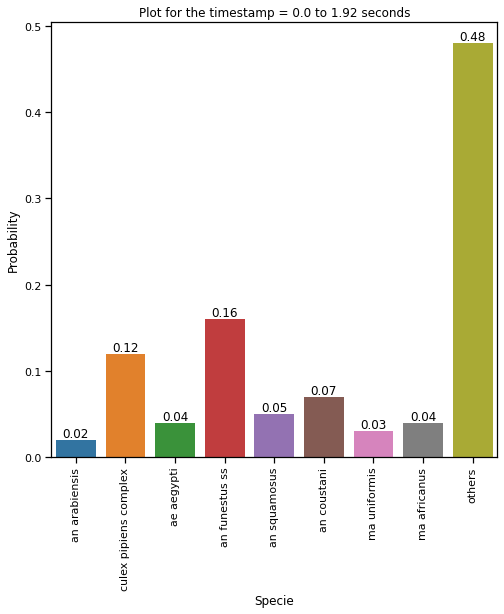

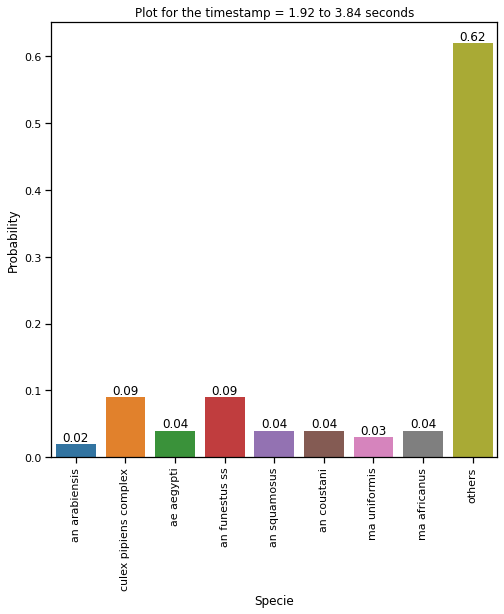

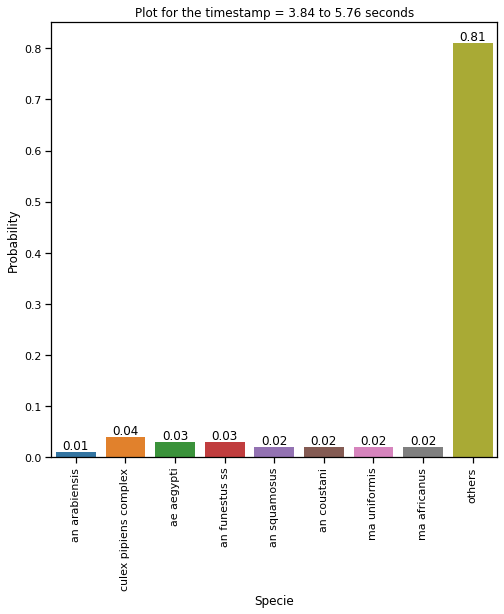

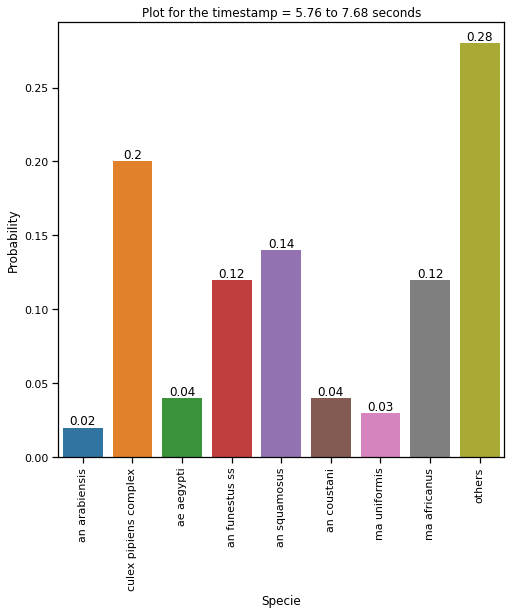

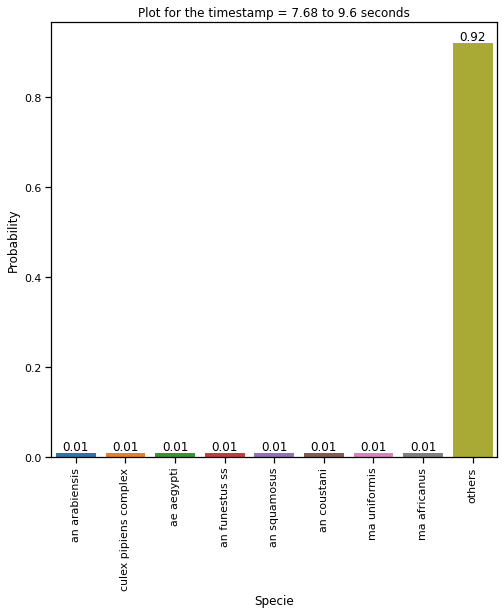

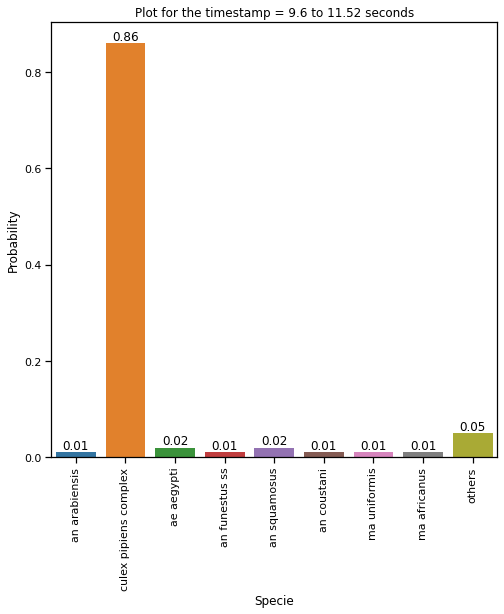

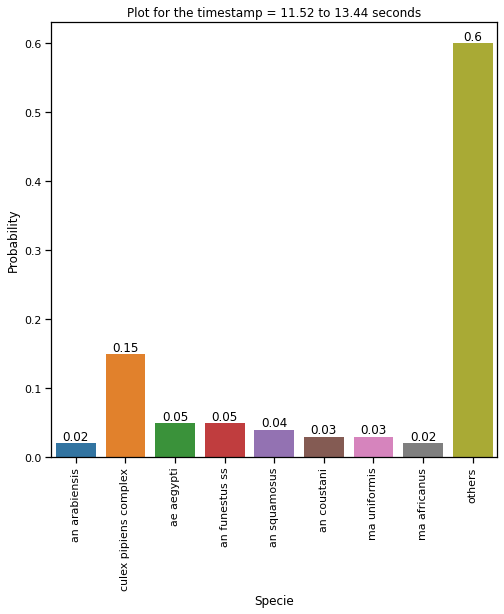

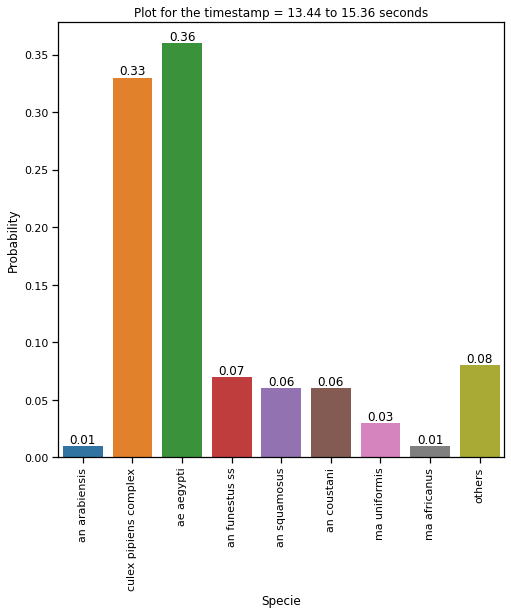

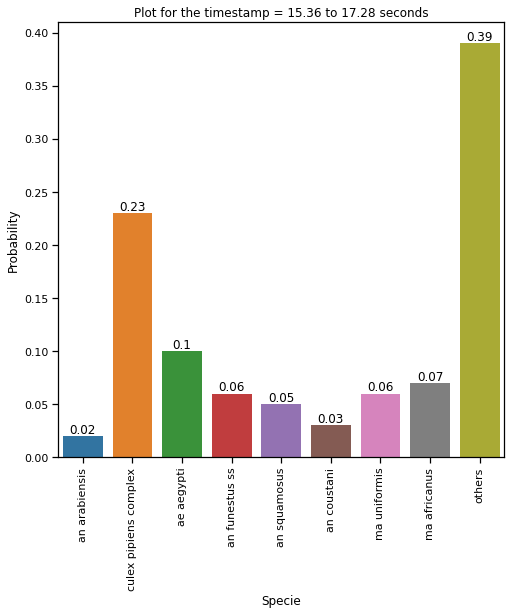

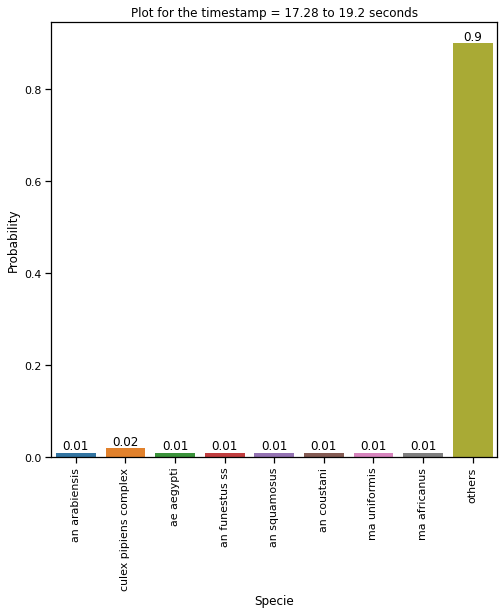

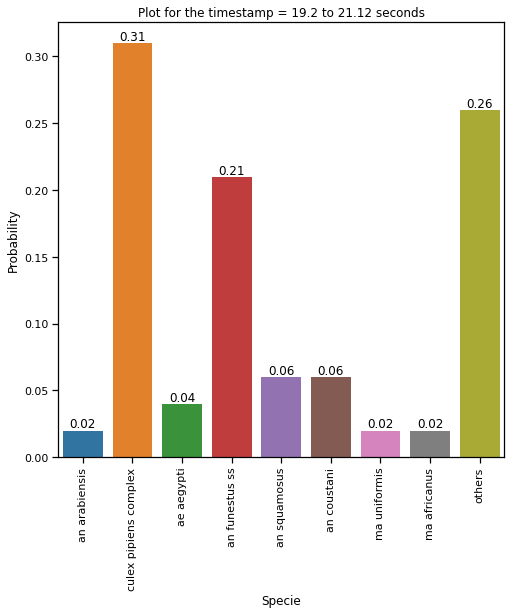

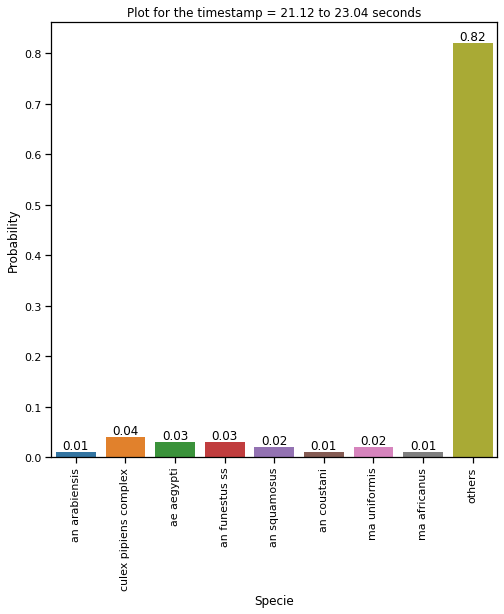

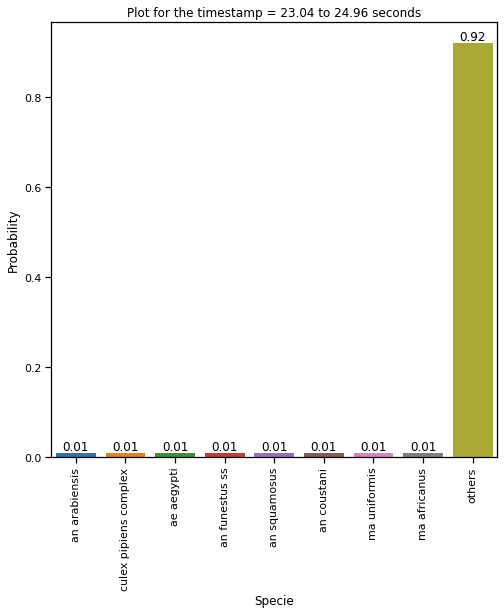

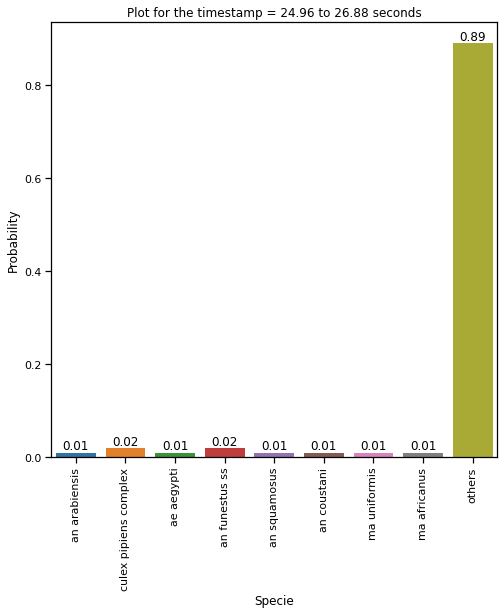

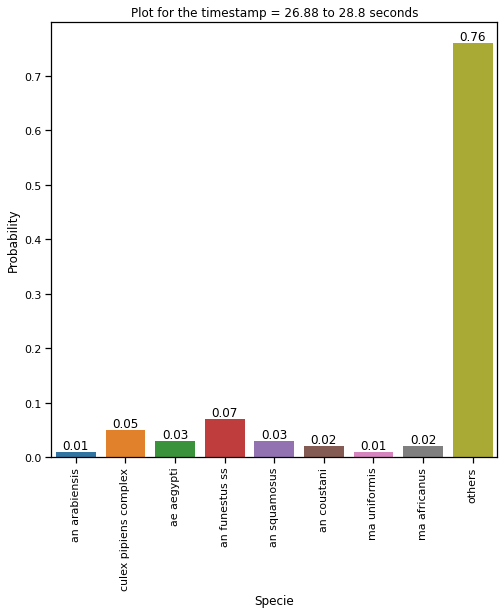

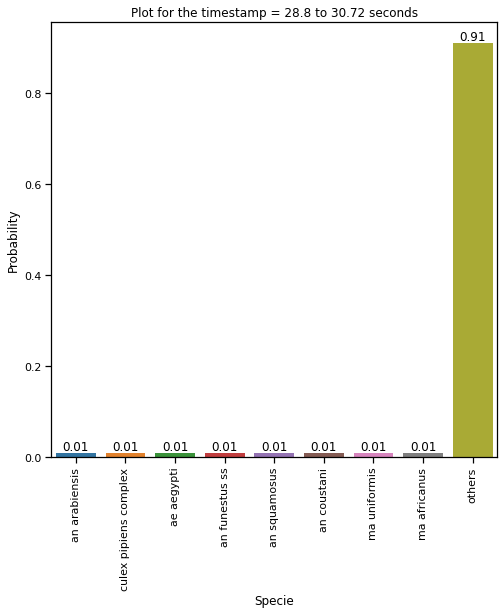

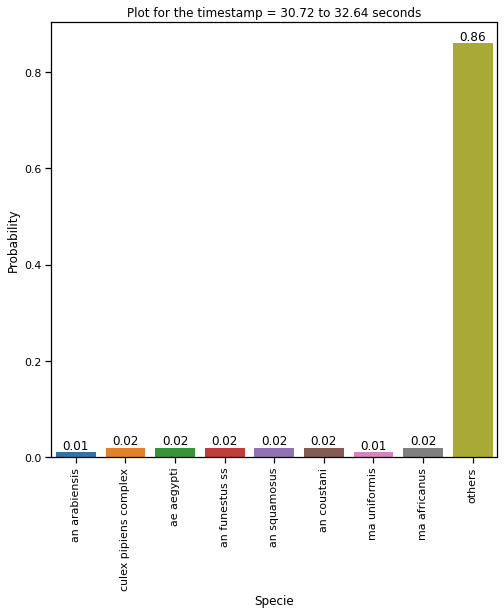

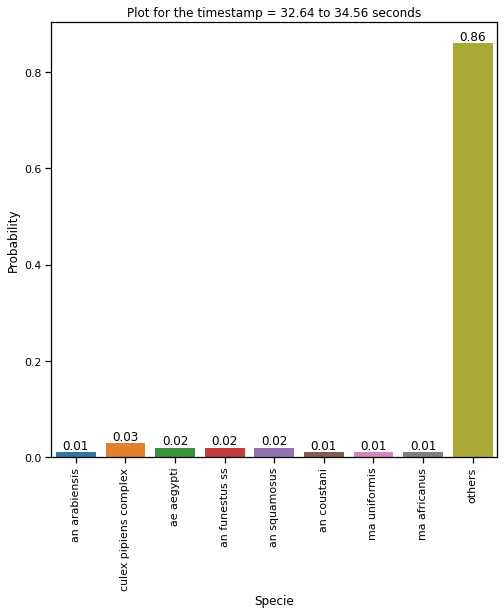

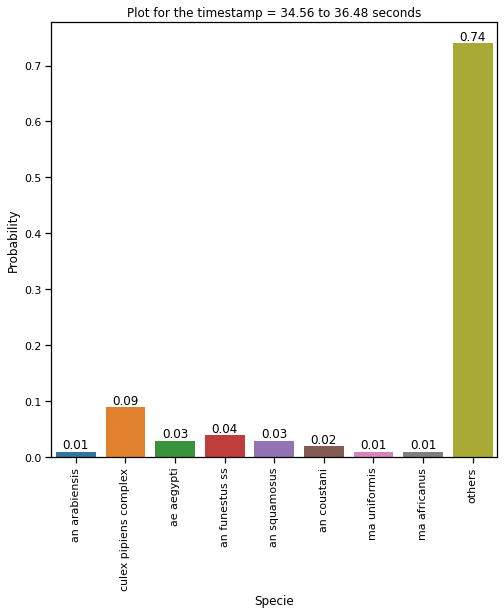

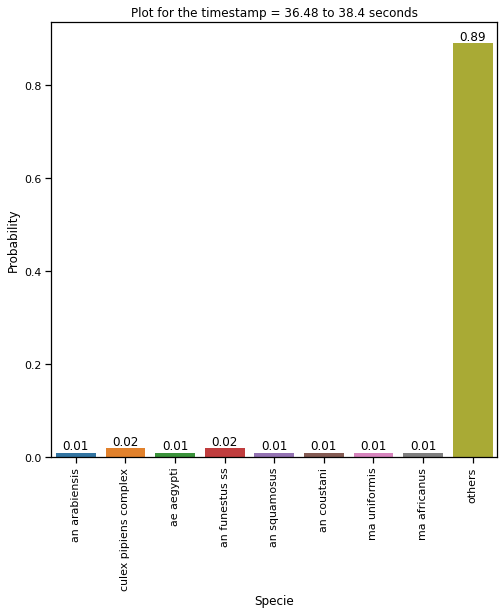

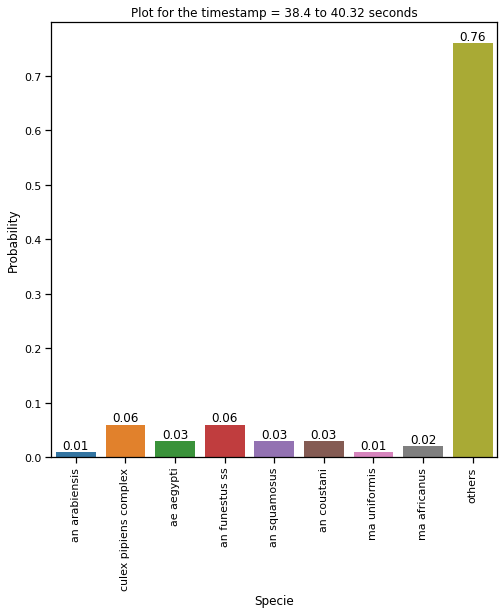

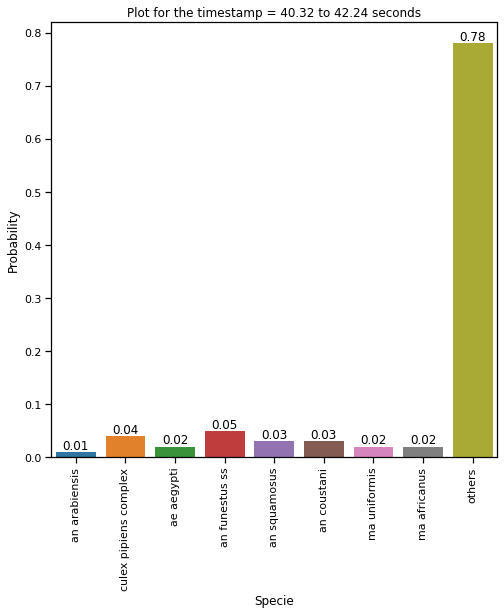

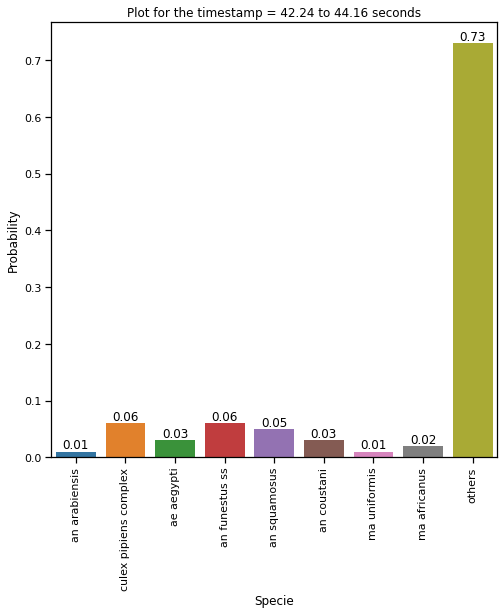

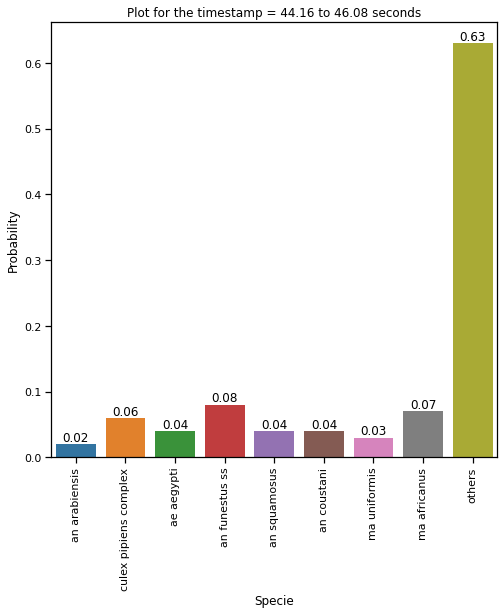

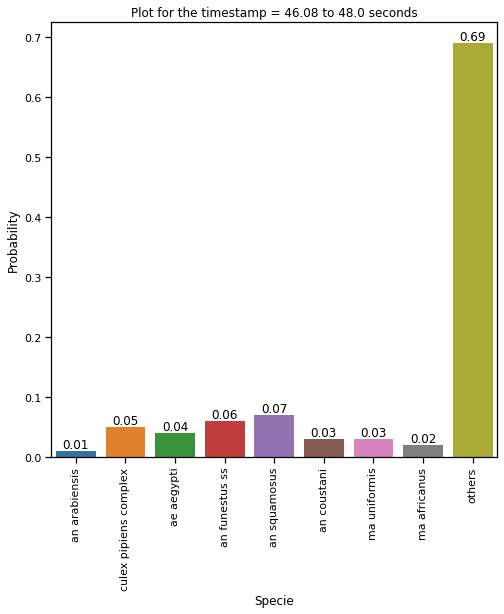

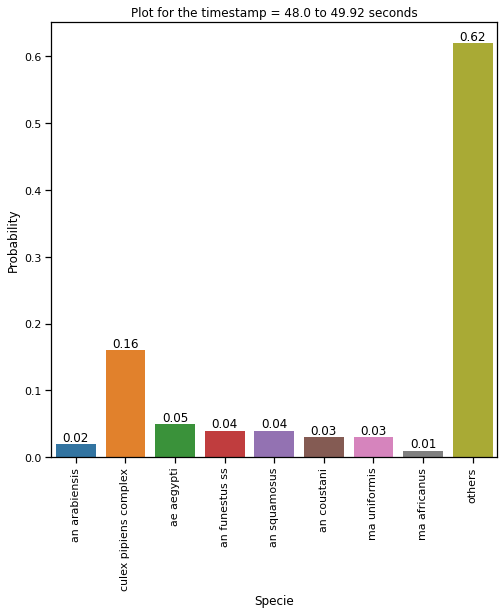

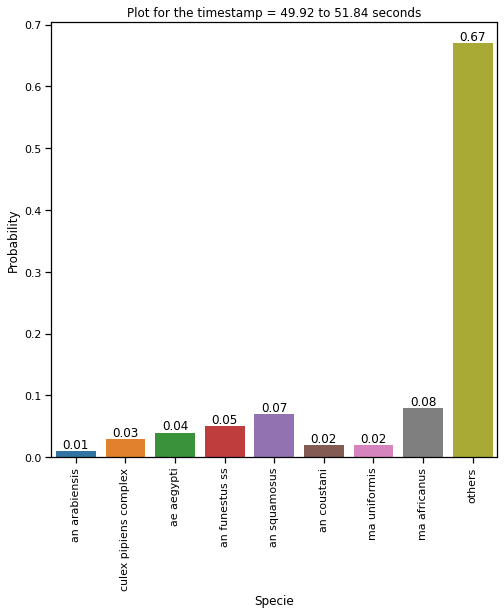

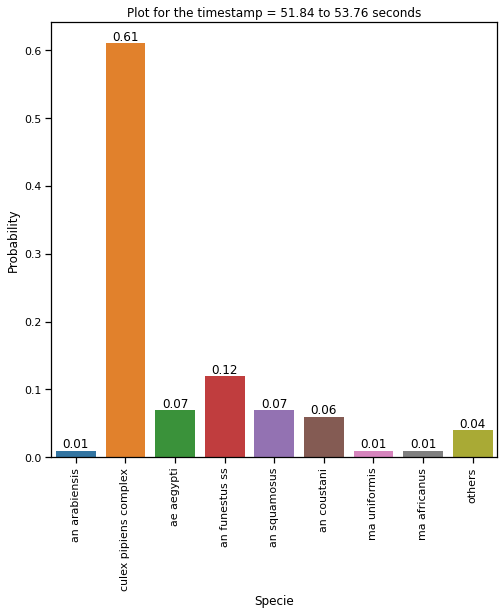

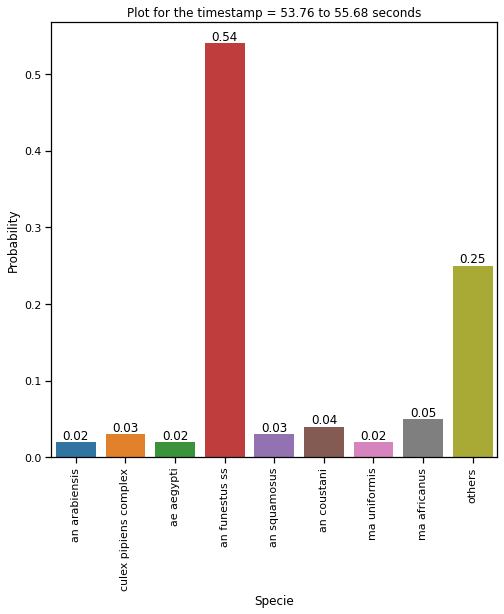

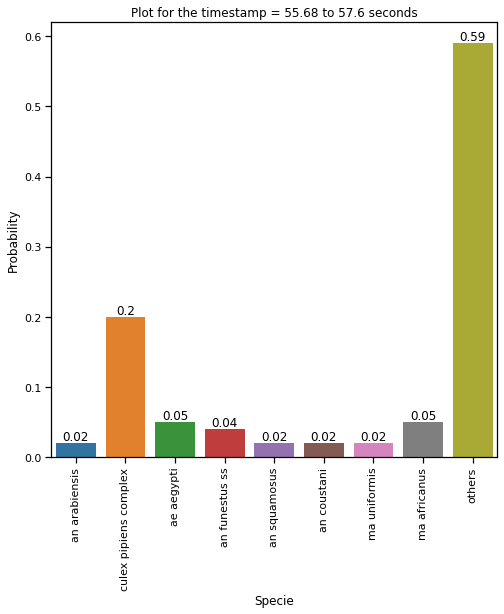

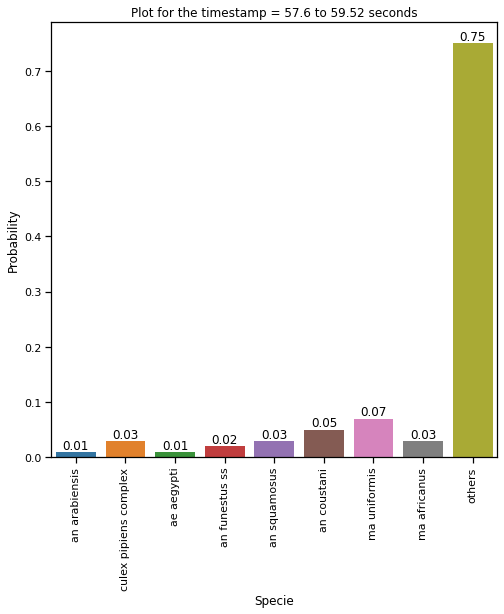

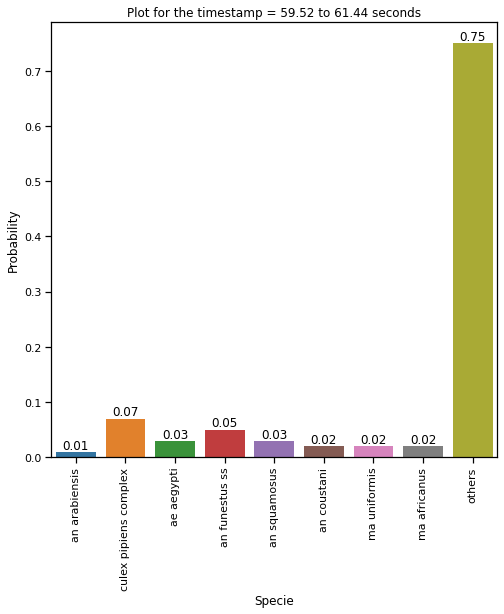

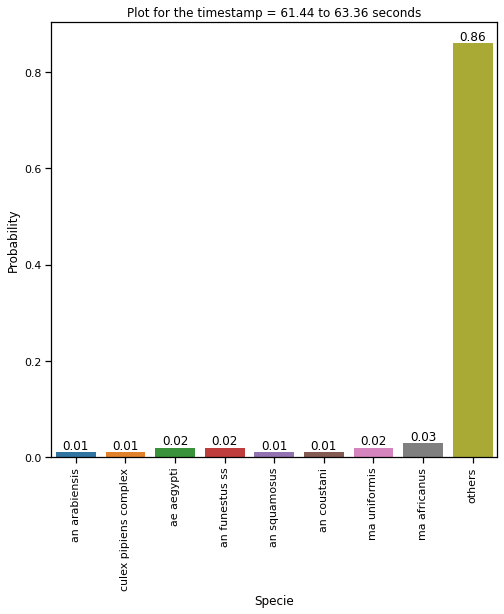

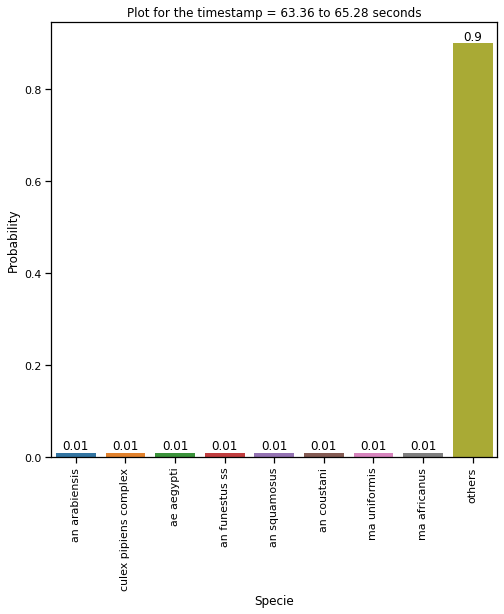

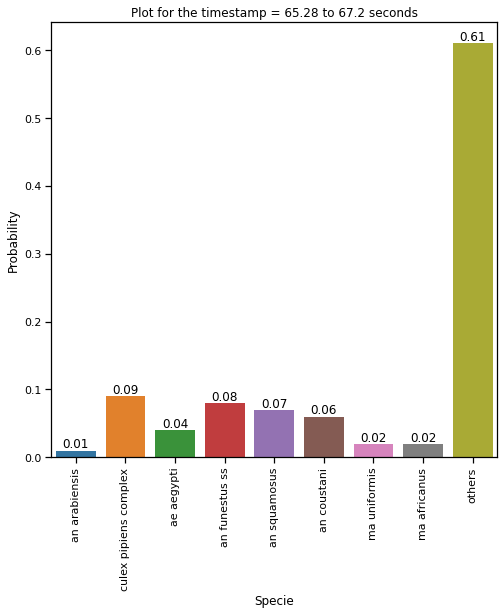

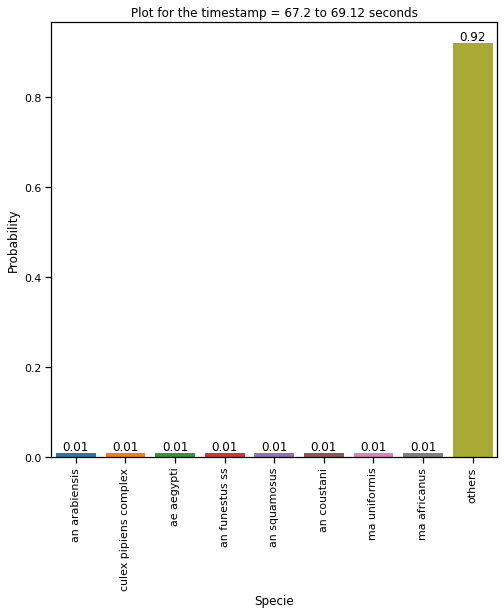

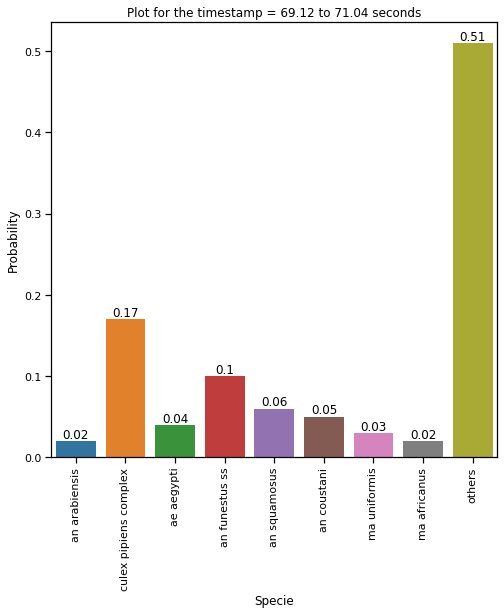

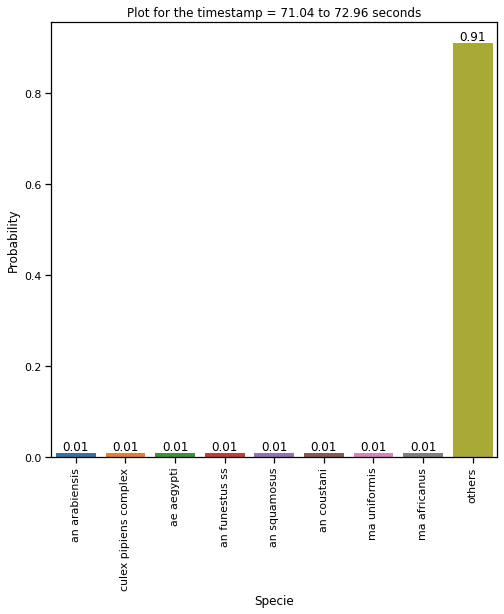

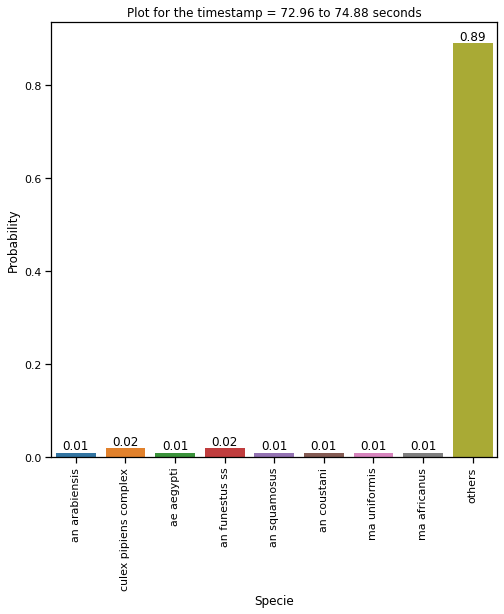

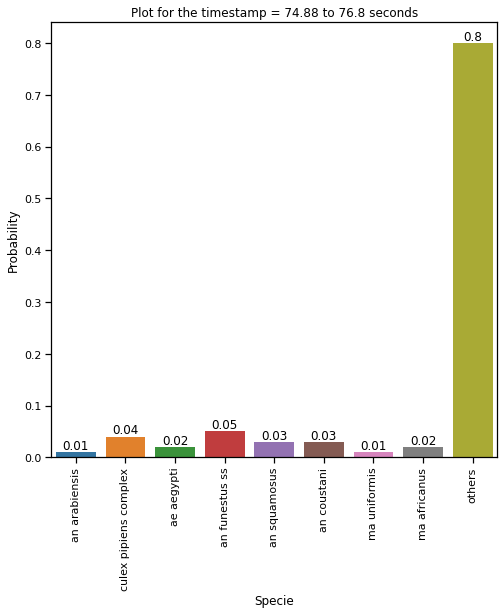

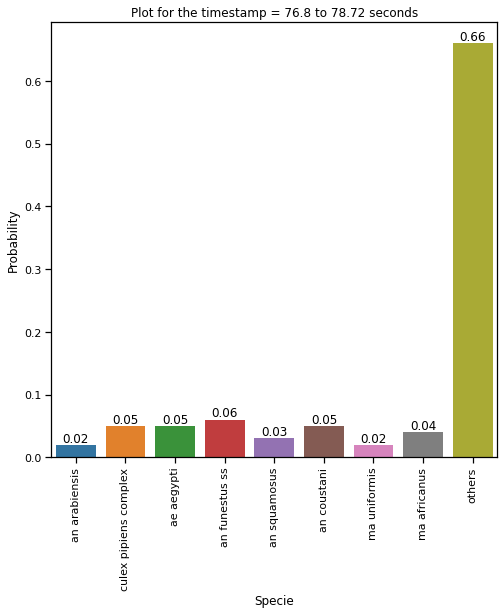

In [34]:
inp = int(219958)
inf_file = "../data/audio/" + str(inp) +".wav"
print(inf_file)
infer_model(model_MED, model_MSC ,inf_file , classes)
